In [1]:
# !pip install "git+ssh://git@github.com/MindSetLib/MS-InsuranceScoring.git@InsolverPackage#egg=insolver"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import hp

In [3]:
from insolver.InsolverDataFrame import InsolverDataFrame
from insolver.InsolverTransforms import (
    TransformExp,
    InsolverTransformMain,
    InsolverTransforms,
    TransformAge,
    TransformMapValues,
    TransformPolynomizer,
    TransformAgeGender,
)
from insolver.InsolverWrapperGBM import InsolverGradientBoostingWrapper
from insolver.InsolverPlotsGBM import PredictionPlots, ShapPlots
from insolver.InsolverWrapperGLM import InsolverGLMWrapper
from insolver.InsolverUtils import train_val_test_split

In [4]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [5]:
df = df[df.Dataset.isin([5,6,7,8,9])]
df.dropna(how='all', axis=1, inplace=True)
df = df[df.ClaimAmount > 0]

In [6]:
InsDataFrame = InsolverDataFrame(df)

In [7]:
InsDataFrame.head(7)

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,...,ClaimAmount,ClaimInd,Dataset,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
145813,0.617,602,2004-05-19,NaN,Male,Other,CSP60,Private,68,0,...,5377.204532,1,5,1.0,0.0,1.0,0.0,1.0,0.0,4.0
145814,0.761,357,2004-01-01,2004-10-05,Female,Alone,CSP55,Private+trip to office,47,0,...,2017.843505,1,5,0.0,1.0,0.0,0.0,0.0,0.0,6.0
145833,0.023,271,2004-10-23,2004-11-01,Male,Other,CSP50,Private+trip to office,49,0,...,356.773414,1,5,0.0,1.0,0.0,0.0,0.0,2.0,8.0
145845,0.833,539,2004-01-01,2004-11-01,Male,Other,CSP60,Private,75,0,...,645.125982,1,5,0.0,0.0,0.0,0.0,0.0,0.0,9.0
145846,0.957,302,2004-01-01,2004-12-16,Female,Other,CSP55,Private+trip to office,49,0,...,1200.422356,1,5,0.0,0.0,0.0,0.0,1.0,0.0,8.0
145850,0.611,525,2004-05-21,NaN,Male,Other,CSP60,Private,68,1,...,4326.525680,1,5,0.0,0.0,0.0,0.0,0.0,0.0,10.0
145863,0.482,343,2004-01-01,2004-06-25,Female,Other,CSP1,Professional,48,0,...,2667.093353,1,5,0.0,0.0,1.0,0.0,1.0,0.0,9.0


In [8]:
InsDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15532 entries, 145813 to 310976
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Exposure           15532 non-null  float64
 1   LicAge             15532 non-null  int64  
 2   RecordBeg          15532 non-null  object 
 3   RecordEnd          8168 non-null   object 
 4   Gender             15532 non-null  object 
 5   MariStat           15532 non-null  object 
 6   SocioCateg         15532 non-null  object 
 7   VehUsage           15532 non-null  object 
 8   DrivAge            15532 non-null  int64  
 9   HasKmLimit         15532 non-null  int64  
 10  BonusMalus         15532 non-null  int64  
 11  ClaimAmount        15532 non-null  float64
 12  ClaimInd           15532 non-null  int64  
 13  Dataset            15532 non-null  int64  
 14  ClaimNbResp        15532 non-null  float64
 15  ClaimNbNonResp     15532 non-null  float64
 16  ClaimNbParking  

In [9]:
InsDataFrame.get_meta_info()

{'type': 'InsolverDataFrame',
 'len': 15532,
 'columns': [{'name': 'Exposure', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'LicAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'RecordBeg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'RecordEnd', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'Gender', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'MariStat', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'SocioCateg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehUsage', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'DrivAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'HasKmLimit', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'BonusMalus', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'ClaimAmount', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'ClaimInd', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'Dataset', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'ClaimNbRe

In [10]:
@staticmethod
def exp_new(exp, exp_max):
    if pd.isnull(exp):
        exp = None
    elif exp < 0:
        exp = None
    else:
        exp = exp * 7 // 365
    if exp > exp_max:
        exp = exp_max
    return exp

TransformExp._exp = exp_new

In [11]:
class TransformSocioCateg(InsolverTransformMain):
    def __init__(self, column_socio_categ):
        self.priority = 0
        super().__init__()
        self.column_socio_categ = column_socio_categ

    def __call__(self, df):
        df[self.column_socio_categ] = df[self.column_socio_categ].str.slice(0,4)
        return df

In [12]:
class TransformToNumeric(InsolverTransformMain):
    def __init__(self, column_param, downcast='integer'):
        self.priority = 0
        super().__init__()
        self.column_param = column_param
        self.downcast = downcast

    def __call__(self, df):
        df[self.column_param] = pd.to_numeric(df[self.column_param], downcast=self.downcast)
        return df

In [13]:
InsTransforms = InsolverTransforms(InsDataFrame.get_data(), [
    TransformAge('DrivAge', 18, 75),
    TransformExp('LicAge', 57),
    TransformMapValues('Gender', {'Male':0, 'Female':1}),
    TransformMapValues('MariStat', {'Other':0, 'Alone':1}),
    TransformSocioCateg('SocioCateg'),
    TransformAgeGender('DrivAge', 'Gender', 'Age_m', 'Age_f', age_default=18, gender_male=0, gender_female=1),
    TransformPolynomizer('Age_m'),
    TransformPolynomizer('Age_f'),
    # TransformToNumeric('VehAge'),
    # T.TransformVehAge('VehAge', 20),
    ])

In [14]:
InsTransforms.transforms

In [15]:
InsTransforms.transform()

{'TransformSocioCateg': {'column_socio_categ': 'SocioCateg', 'priority': 0},
 'TransformAge': {'age_max': 75,
  'age_min': 18,
  'column_driver_minage': 'DrivAge',
  'priority': 1},
 'TransformExp': {'column_driver_minexp': 'LicAge',
  'exp_max': 57,
  'priority': 1},
 'TransformMapValues': {'column_param': 'MariStat',
  'dictionary': {'Other': 0, 'Alone': 1},
  'priority': 1},
 'TransformAgeGender': {'age_default': 18,
  'column_age': 'DrivAge',
  'column_age_f': 'Age_f',
  'column_age_m': 'Age_m',
  'column_gender': 'Gender',
  'gender_female': 1,
  'gender_male': 0,
  'priority': 2},
 'TransformPolynomizer': {'column_param': 'Age_f', 'n': 2, 'priority': 3}}

In [16]:
InsTransforms.head(7)

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,...,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,Age_m,Age_f,Age_m_2,Age_f_2
145813,0.617,11,2004-05-19,NaN,0,0,CSP6,Private,68,0,...,0.0,1.0,0.0,1.0,0.0,4.0,68,18,4624,324
145814,0.761,6,2004-01-01,2004-10-05,1,1,CSP5,Private+trip to office,47,0,...,1.0,0.0,0.0,0.0,0.0,6.0,18,47,324,2209
145833,0.023,5,2004-10-23,2004-11-01,0,0,CSP5,Private+trip to office,49,0,...,1.0,0.0,0.0,0.0,2.0,8.0,49,18,2401,324
145845,0.833,10,2004-01-01,2004-11-01,0,0,CSP6,Private,75,0,...,0.0,0.0,0.0,0.0,0.0,9.0,75,18,5625,324
145846,0.957,5,2004-01-01,2004-12-16,1,0,CSP5,Private+trip to office,49,0,...,0.0,0.0,0.0,1.0,0.0,8.0,18,49,324,2401
145850,0.611,10,2004-05-21,NaN,0,0,CSP6,Private,68,1,...,0.0,0.0,0.0,0.0,0.0,10.0,68,18,4624,324
145863,0.482,6,2004-01-01,2004-06-25,1,0,CSP1,Professional,48,0,...,0.0,1.0,0.0,1.0,0.0,9.0,18,48,324,2304


In [17]:
InsTransforms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15532 entries, 145813 to 310976
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Exposure           15532 non-null  float64
 1   LicAge             15532 non-null  int64  
 2   RecordBeg          15532 non-null  object 
 3   RecordEnd          8168 non-null   object 
 4   Gender             15532 non-null  int64  
 5   MariStat           15532 non-null  int64  
 6   SocioCateg         15532 non-null  object 
 7   VehUsage           15532 non-null  object 
 8   DrivAge            15532 non-null  int64  
 9   HasKmLimit         15532 non-null  int64  
 10  BonusMalus         15532 non-null  int64  
 11  ClaimAmount        15532 non-null  float64
 12  ClaimInd           15532 non-null  int64  
 13  Dataset            15532 non-null  int64  
 14  ClaimNbResp        15532 non-null  float64
 15  ClaimNbNonResp     15532 non-null  float64
 16  ClaimNbParking  

In [18]:
InsTransforms.get_meta_info()

{'type': 'InsolverDataFrame',
 'len': 15532,
 'columns': [{'name': 'Exposure', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'LicAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'RecordBeg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'RecordEnd', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'Gender', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'MariStat', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'SocioCateg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehUsage', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'DrivAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'HasKmLimit', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'BonusMalus', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'ClaimAmount', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'ClaimInd', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'Dataset', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'C

In [19]:
train, valid, test = InsTransforms.split_frame(val_size=0.15, test_size=0.15, random_state=0, shuffle=True)

In [20]:
features = ['LicAge', 'Gender', 'MariStat', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'RiskArea',
            'Age_m', 'Age_f', 'Age_m_2', 'Age_f_2']
target = 'ClaimAmount'

In [21]:
iglm = InsolverGLMWrapper()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.251-b08, mixed mode, sharing)


  You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.



  Starting server from c:\users\thinkpad\pycharmprojects\ms-insurancescoring\venv\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Thinkpad\AppData\Local\Temp\tmppvt37roc
  JVM stdout: C:\Users\Thinkpad\AppData\Local\Temp\tmppvt37roc\h2o_Thinkpad_started_from_python.out
  JVM stderr: C:\Users\Thinkpad\AppData\Local\Temp\tmppvt37roc\h2o_Thinkpad_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_Thinkpad_2hjc2d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [22]:
iglm.model_init(train, valid, family='gamma', link='log')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0],
          'alpha': [i * 0.1 for i in range(0, 11)]}

In [24]:
iglm.grid_search_cv(features, target, params, search_criteria={'strategy': "Cartesian"})
# iglm.fit(features, target, train, valid)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [25]:
predict_glm = iglm.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [26]:
iglm.save_model('glm')

In [27]:
igbm = InsolverGradientBoostingWrapper(algorithm='xgboost', task='regression')

In [28]:
space_xgboost = {"objective": 'reg:gamma',
                 "max_depth": hp.choice('max_depth', [5, 8, 10, 12, 15]),
                 "min_child_weight": hp.uniform('min_child_weight', 0, 50),
                 "subsample": hp.uniform('subsample', 0.5, 1),
                 "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1),
                 "alpha": hp.uniform('alpha', 0, 1),
                 "lambda": hp.uniform('lambda', 0, 1),
                 "eta": hp.uniform('eta', 0.01, 1),
                 "gamma": hp.uniform('gamma', 0.01, 1000),
                 "tree_method": 'hist'}

In [29]:
cv_par = {'num_boost_round': 250,
          'nfold': 3,
          'early_stopping_rounds': 20,
          'seed': 0,
          'shuffle': True,
          'stratified': False}

In [30]:
x_train, y_train = train[features], train[target]
x_valid, y_valid = valid[features], valid[target]
x_test, y_test = test[features], test[target]

In [31]:
igbm.hyperopt_cv(x_train, y_train, space_xgboost, cv_par, max_evals=250)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:41<00:00,  1.85s/trial, best loss: 8.629924333333333]


In [32]:
igbm.model_init()

In [33]:
igbm.fit(x_train, y_train)

[23:13:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [34]:
predict_gbm1 = igbm.predict(x_test)

In [35]:
igbm.fit_booster(x_train, y_train, core_params={'evals': [((x_train, y_train), 'train'),
                                                          ((x_valid, y_valid), 'valid')],
                                                'verbose_eval': False})

In [36]:
predict_gbm2 = igbm.predict_booster(x_test)

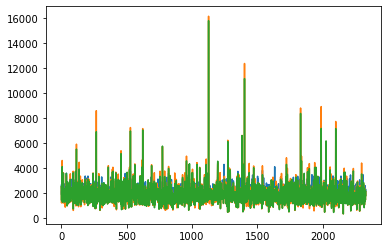

In [37]:
plt.plot(predict_glm)
plt.plot(predict_gbm1)
plt.plot(predict_gbm2)
plt.show()